Accuracy Testing achieved using k-fold Cross Validation (k=1000 here) and choosing few folds for subsampling to reduce computational burden

In [8]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import KFold

Breaking dataset into 1000 train and val sets. Then choosing 5 out of the 1000 to reduce computational work:

In [9]:
k=1000
k_datasets_maker = KFold(n_splits=k, shuffle=True, random_state=42)
train_datasets=[]
val_datasets=[]
final_processed_data=pd.read_csv(r"Final_Processed_Dataset.csv")
reviewers=final_processed_data["ReviewerName"].unique()

#Subsampling from among 1000 folds to 5
a=[i for i in range(1000)]
import random
random.shuffle(a)
b=a[0:5]

split_data=list(k_datasets_maker.split(reviewers))

for i in b:
    train_idx=split_data[i][0]
    val_idx=split_data[i][1]
    train_reviewers = reviewers[train_idx]
    val_reviewers = reviewers[val_idx]

    train_data = final_processed_data[final_processed_data["ReviewerName"].isin(train_reviewers)]
    val_data = final_processed_data[final_processed_data["ReviewerName"].isin(val_reviewers)]

    train_datasets.append(train_data)
    val_datasets.append(val_data)

Dividing val set entries into 2 parts : one that will be required for calculating similarity with other users and other that will serve as ground truth

In [10]:
reviewers_for_val_sets=[]
ground_truths=[]

for i in range(5):
    val_data_iteration=val_datasets[i]
    reviewers_for_val_sets.append(val_data_iteration["ReviewerName"].unique())
    
    ground_truth=[]

    for j in reviewers_for_val_sets[-1]:
        half_size = val_data_iteration[val_data_iteration["ReviewerName"] == j].shape[0] // 2
        actual_vals = val_data_iteration[val_data_iteration["ReviewerName"] == j].iloc[:half_size]
        rest_data = val_data_iteration[val_data_iteration["ReviewerName"] == j].iloc[half_size:]
        train_datasets[i]=pd.concat([train_datasets[i],rest_data])
        ground_truth.append(actual_vals)
    
    ground_truths.append(pd.concat(ground_truth))
# print(ground_truths)
# for i in ground_truths:
#     print(i.shape)

Collaborative filtering precision on a pair of train and val dataset calculator function :

In [11]:
def collab_filter(train_set_iteration,val_set_reviewers,ground_truth):
    reviewer_recipe_rating_matrix = train_set_iteration.pivot_table(index='ReviewerName', columns='Name', values='Rating')

    def normalise_rating(user_ratings):
        return user_ratings/user_ratings.sum()*user_ratings.count()

    reviewer_recipe_rating_matrix=reviewer_recipe_rating_matrix.apply(normalise_rating,axis=1)
    reviewer_recipe_rating_relation_matrix=reviewer_recipe_rating_matrix.fillna(0)

    from scipy.sparse import csr_matrix
    reviewer_recipe_rating_relation_matrix=csr_matrix(reviewer_recipe_rating_relation_matrix.values)
    cosine_similarity_matrix=cosine_similarity(reviewer_recipe_rating_relation_matrix)
    cosine_similarity_matrix = pd.DataFrame(cosine_similarity_matrix, index=reviewer_recipe_rating_matrix.index, columns=reviewer_recipe_rating_matrix.index)

    precision_array=[]

    for user in val_set_reviewers:
        user_similarity=cosine_similarity_matrix[user]
        user_similarity.drop(user,inplace=True)
        user_similarity=user_similarity.reset_index()
        reviewer_recipe_rating_matrix_temp=reviewer_recipe_rating_matrix.reset_index()

        user_data=reviewer_recipe_rating_matrix_temp[reviewer_recipe_rating_matrix_temp["ReviewerName"]==user]
        user_data=user_data.drop("ReviewerName",axis=1)
        already_rated = user_data.loc[:, user_data.notna().any()]
        reviewer_recipe_rating_matrix_temp.drop(columns=already_rated.columns.tolist(),inplace=True)

        def apply_similarity_weights(row):
            return row*row.loc[user]

        merged_data=pd.merge(user_similarity,reviewer_recipe_rating_matrix_temp,on="ReviewerName")
        merged_data.drop("ReviewerName",axis=1,inplace=True)
        merged_data=merged_data.apply(apply_similarity_weights,axis=1)

        def weighted_ratings(column):
            return column/column.count()
        
        merged_data=merged_data.apply(weighted_ratings,axis=0)
        merged_data.drop(user,axis=1,inplace=True)

        top_5_recommend=set(merged_data.sum(axis=0).sort_values(ascending=False).iloc[0:5].reset_index()["index"])
        #Fetching actual top 5 ratings of dishes that have not been tasted yet:
        actual_top_5=set(ground_truth[ground_truth["ReviewerName"]==user][["Name", "Rating"]].sort_values(by="Rating",ascending=False).head(5)["Name"])
        #Calculating precision of predictions for a specific user :
        c=len(top_5_recommend.intersection(actual_top_5))
        precision_array.append(c/5)
    #Overall precision for val dataset
    return sum(precision_array)/len(precision_array)

Calculating precision at K accuracy for all 5 subsets of k-fold

In [12]:
precision_lst=[]
for i in range(5):
    precision_lst.append(collab_filter(train_datasets[i],reviewers_for_val_sets[i],ground_truths[i]))

Creating graph for precision for each cross validation subdataset :

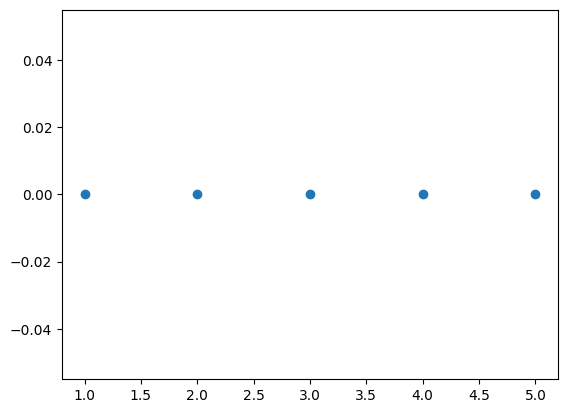

In [13]:
import matplotlib.pyplot as plt
plt.scatter(x=[1,2,3,4,5],y=precision_lst,label="Precision Graph")
plt.show()

Overall Accuracy

In [14]:
print(sum(precision_lst)/5*100)

0.0


We get extremely poor accuracy as data is sparse in cosine similarity matrix. Most dishes being suggested are simply those which are liked by most as hardly any preference of users is matching due to sparseness.
Hence, weights for each user's rating are not getting calculated as desired.

Also, we are using the user's already rated dishes for ground_truth. As most user have hardly tried any dishes, hence the suggested dishes (from among 14000 dishes) may not belong to the small set of grounf truth anyways! There might exist many better dishes suited for user than the ones he has already tried (used as ground truth).

This issue might get rectified if all users have tried a lot of dishes. (User-Recipe-Rating matrix is not sparse)

However this is unlikely to be a practical case in an actual food recommender system.